# Tuango - RFM Analysis for Mobile App Push Messaging

This project is based on a new way of purchase known as tuango in China, which is similar with groupon in the US.Messages of tuango for certain products are sent to customers to commit purchases. Too much less relevant messages would make customer feel the app bothering and useless.
What we have is the response recevied after message of tuango for karaoke sent to 10% of the whole dataset. RFM analysis would be mainly used here to figure out who in the other 90% of customers would received the message to make profit and ROME as large as possible.

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyrsm import xtile, seprop
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from tempfile import NamedTemporaryFile as tmpfile

In [290]:
tuango=pd.read_pickle('tuango.pkl')

In [291]:
tuango.head()

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os
0,U12617430,309,7,39.8,514,no,0.0,App,3,android
1,U63302737,297,8,39.8,514,no,0.0,Browser,3,android
2,U77095928,295,1,72.9,553,no,0.0,Browser,3,android
3,U43509181,277,1,40.0,554,no,0.0,Browser,3,android
4,U23195941,259,1,21.0,555,no,0.0,App,3,android


### I.Preliminary and Quintile Analysis

Firstly, the response rate in the whole sample set could tell us a full picture of customers' willing to resonde.

In [292]:
resp_rate=np.nanmean(tuango['buyer']=='yes')*100
print('The percentage of customers reponded is {}%'.format(round(resp_rate,3)))

The percentage of customers reponded is 2.981%


For the customers who actually respond the offer and purchase Karaoke, the average ordersize could help us know about the consumption ability.

In [293]:
avg_amount=np.nanmean(tuango[tuango['buyer']=='yes']['ordersize'])
print('The average amount spent on the karaoke deal by customers that bought one(or more) is ${}'.format(round(avg_amount,2)))

The average amount spent on the karaoke deal by customers that bought one(or more) is $202.13


Then the quintiles for each fields(recency,frequency,monetary) should be created to take a more descriptive look on customers.Recency is days since last purchase, frequency is the number of deals the customer purchased  and monetary is average amount spent per order. 

In [294]:
tuango['rec_iq']=xtile(tuango['recency'],5)
tuango['fre_iq']=xtile(tuango['frequency'],5,rev=True)
tuango['mon_iq']=xtile(tuango['monetary'],5,rev=True)

After creating quintiles for recency,frequency and monetary fields, response rate and average amount of each group could be interpreted for details.
Here are two functions for groupping and ploting bar charts.

In [295]:
def prop_calc(df, group, rvar, lev):
    """Calculate proportions per value of the grouping variable"""
    df["rvar_int"] = np.where(df[rvar] == lev, 1, 0)
    df = df.groupby(group)
    return df["rvar_int"].agg(prop="mean").reset_index().rename(columns={"prop": rvar})


def prop_plot(df, lev, breakeven=0):
    """Plot return from the prop_calc function"""
    plt.clf()
    cn = df.columns
    fig = sns.barplot(x=cn[0], y=cn[1], color="blue", data=df)
    fig.set(ylabel=f"Proportion of {cn[1]} = '{lev}'")
    if breakeven > 0:
        fig.axhline(breakeven, linestyle="dashed", linewidth=0.5)
    plt.show()

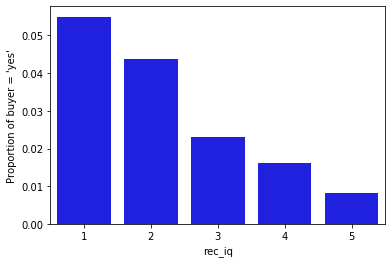

In [296]:
props=prop_calc(tuango,'rec_iq','buyer','yes')
prop_plot(props,'yes')

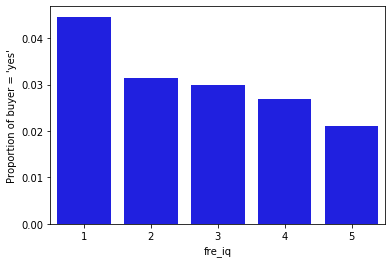

In [297]:
props=prop_calc(tuango,'fre_iq','buyer','yes')
prop_plot(props,'yes')

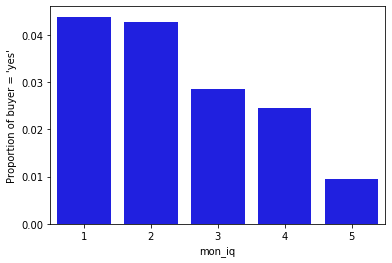

In [298]:
props=prop_calc(tuango,'mon_iq','buyer','yes')
prop_plot(props,'yes')

In [299]:
tuango_buyer=tuango[tuango.buyer == 'yes']

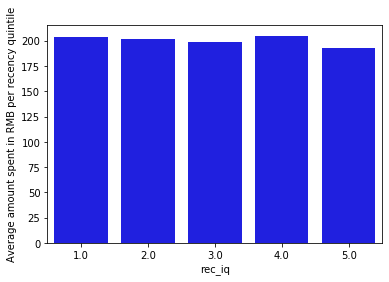

In [300]:
rec_iq_order=tuango_buyer.groupby(tuango['rec_iq']).mean()
fig = sns.barplot(x = 'rec_iq',y = 'ordersize',data=rec_iq_order,color='blue')
plt.ylabel('Average amount spent in RMB per recency quintile')
plt.show()

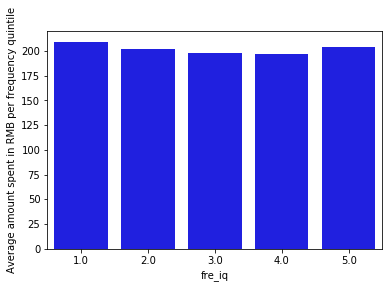

In [301]:
fre_iq_order=tuango_buyer.groupby(tuango['fre_iq']).mean()
fig = sns.barplot(x = 'fre_iq',y = 'ordersize',data=fre_iq_order,color='blue')
plt.ylabel('Average amount spent in RMB per frequency quintile')
plt.show()

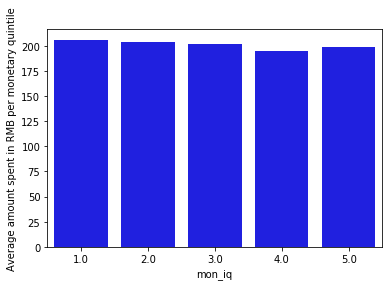

In [302]:
mon_iq_order=tuango_buyer.groupby(tuango['mon_iq']).mean()
sns.barplot(x='mon_iq',y='ordersize',data=mon_iq_order,color='blue')
plt.ylabel('Average amount spent in RMB per monetary quintile')
plt.show()

The probability of response is descending as quintiles of recency,frequency and monetary go from 1 to 5.
However, the difference between each two adjacent bins of recency are similar with the highest probability almost five times of the lowest one. 

For frequency, the highest probability of response is way much higher than the other four.Customers in the group with largest frequency are much more likely to responde the message than the other four while the difference brought by frequency is not obvious in the other four groups.

For monetary, the top two bins with the highest probability of response are similar but much higher than the other three.Customers whose average ordersize are in the top 2 groups are much more likely to responde messages than the other three bins. 

As for the ordersize, it shows that for customer who have placed orders, the difference brought by recency,frequency and monetary is not as obvious as response rate.

### II. Profitability analysis

Create 125 rfm indexs by clinging the three labels together.

In [303]:
tuango['rfm_iq']=tuango['rec_iq'].astype(str)+tuango['fre_iq'].astype(str)+tuango['mon_iq'].astype(str)

Since the revenue is the product of responses received and amounts of each order and 50% with the assumption that karaoke would take the other 50%, the formula of breakeven is shown below.The breakeven base on the whole picture of sample set.

In [304]:
breakeven=2.5/(avg_amount*0.5)*100
print('The breakeven response rate is {}%'.format(round(breakeven,3)))

The breakeven response rate is 2.474%


If we typically send messages to all the other customers, we assume that the average amount of orders would be the same as that of the sample set as $202.13. 
Also, the response rate is assumed same as sample set.

In [305]:
perc_mail = 1.0
nr_mail = 250902 * perc_mail
rep_rate = np.nanmean(tuango['buyer']=='yes')
nr_resp = nr_mail * rep_rate
mail_cost = 2.5 * nr_mail
revenue = avg_amount * nr_resp*0.5
profit_nt = revenue - mail_cost
ROME_nt = profit_nt / mail_cost

In [306]:
print(
    f"""Without targeting BBB would mail all {int(nr_mail):,} ({round((100 * perc_mail), 2)}%) customers.
The response rate for the selected customers is predicted to be {round((100 * rep_rate), 2)}% or {int(nr_resp):,}
buyers. The revenue is equal to ${int(revenue):,}. The expected profit is ${int(profit_nt):,}. The mailing
cost is estimated to be ${int(mail_cost):,} with a ROME of {round((100 * ROME_nt), 2)}%"""
)

Without targeting BBB would mail all 250,902 (100.0%) customers.
The response rate for the selected customers is predicted to be 2.98% or 7,479
buyers. The revenue is equal to $755,860. The expected profit is $128,605. The mailing
cost is estimated to be $627,255 with a ROME of 20.5%


Besides the independent RFM index, sequential RFM index is used as often and we would create another index named rfm_sq to label the customers. Sequential RFM index has the same quintiles of recency with independent RFM index, but the quintiles of frequency are created after grouping data by quintiles of recency and quintiles of monetary are created after grouping data by quintiles of the former two bins.

In [307]:
tuango['fre_sq']=tuango.groupby('rec_iq')['frequency'].transform(xtile,5,rev=True)
tuango['mon_sq']=tuango.groupby(['rec_iq','fre_sq'])['monetary'].transform(xtile,5,rev=True)
tuango['mon_sq']=tuango['mon_sq'].astype(int)
tuango['rfm_sq']=tuango['rec_iq'].astype(str)+tuango['fre_sq'].astype(str)+tuango['mon_sq'].astype(str)

In [308]:
np.nanmean(tuango['rfm_iq'] == tuango['rfm_sq'])

0.6311069660664324

Apparently only 63% of customers have the same index for independent rfm index and sequential rfm index.

In [309]:
def prop_plott(df, lev, breakeven=breakeven):
    """Plot return from the prop_calc function"""
    plt.clf()
    cn = df.columns
    fig = sns.barplot(x=cn[0], y=cn[1], color="blue", data=df)
    fig.set(ylabel=f"Proportion of {cn[1]} = '{lev}'")
    if breakeven > 0:
        fig.axhline(breakeven, linestyle="dashed", linewidth=0.5)
    plt.show()

In [310]:
def response_rate(x):
    return np.mean(x == "yes")
def mailto(x, breakeven):
    return np.mean(x == "yes") > breakeven/100

In [311]:
def perf_calc(group):
    tuango['rfm_resp'] = tuango.groupby(group)['buyer'].transform(response_rate)
    tuango["mailto"] = tuango.groupby(group)["buyer"].transform(mailto, breakeven)
    
    perc_mail = np.nanmean(tuango["mailto"])
    nr_mail = 250902 * perc_mail
    resp_rate = np.nanmean(tuango.query(f"mailto == True")["buyer"] == "yes")
    nr_resp = nr_mail * resp_rate
    deal_cost = 2.5 * nr_mail
    profit = 0.5 * avg_amount * nr_resp - deal_cost
    ROME = profit / deal_cost
    print(f"""With filtering, Tuango would mail all {int(nr_mail):,} ({round((100 * perc_mail), 2)}%) customers.
The response rate for the selected customers is predicted to be {round((100 * resp_rate), 2)}% or {int(nr_resp):,}buyers. 
The projected profit is ${int(profit):,}. 
The cost of offering a deal is estimated to be ${int(deal_cost):,} with a ROME of {round((100 * ROME), 2)}%""")
    return resp_rate, deal_cost, profit, ROME

In [312]:
resp_rate_sq, deal_cost_sq, profit_sq, ROME_sq=perf_calc('rfm_sq')

With filtering, Tuango would mail all 103,734 (41.34%) customers.
The response rate for the selected customers is predicted to be 5.68% or 5,895buyers. 
The projected profit is $336,439. 
The cost of offering a deal is estimated to be $259,335 with a ROME of 129.73%


In [313]:
resp_rate_iq,deal_cost_iq,profit_iq,ROME_iq=perf_calc('rfm_iq')

With filtering, Tuango would mail all 111,708 (44.52%) customers.
The response rate for the selected customers is predicted to be 5.41% or 6,048buyers. 
The projected profit is $331,967. 
The cost of offering a deal is estimated to be $279,270 with a ROME of 118.87%


Independent RFM index bases on the quintiles independently created by recency, frequency and monetary, which means the three fields are considered independently.This index gives us a whole picture of how the three characters perform equally for each customer.
As for sequential RFM, since the importance of the three fields is recency>frequency>monetary, quintiles of frequency are more likely depend on the frequency of customers in the same quntile of recency. Thus,sequential RFM may be more accurate.

Calculations above assume a single breakeven response rate that applies across all cells.Actually, the response rates for different cells are different because the average ordersize could be different for different groups.It may be more realistic if we use different breakeven response rates for calculation.

In [314]:
tuango['rfm_sq_resp']=tuango.groupby('rfm_sq')['buyer'].transform(response_rate)

In [315]:
breakeven=2.5/(tuango[tuango.buyer == 'yes'].groupby('rfm_sq')['ordersize'].mean()*0.5)

In [316]:
breakeven=pd.DataFrame(breakeven)
breakeven.columns=['breakeven']

In [317]:
tuango=tuango.merge(breakeven,how='left',on='rfm_sq')

In [318]:
tuango['breakeven'].fillna(0.02474,inplace=True)

In [319]:
tuango['rfm_sq_mailto']=tuango['rfm_sq_resp']>tuango['breakeven']

In [321]:
perc_mail = np.nanmean(tuango["rfm_sq_mailto"])
nr_mail = 250902 * perc_mail
resp_rate_filtersq = np.nanmean(tuango.query(f"rfm_sq_mailto == True")["buyer"] == "yes")
nr_resp = nr_mail * resp_rate_filtersq
deal_cost_filsq = 2.5 * nr_mail
profit_filsq = 0.5 * avg_amount * nr_resp - deal_cost_filsq
ROME_filsq = profit_filsq / deal_cost_filsq
print(f"""Based on different breakeven response rates, Tuango would mail all {int(nr_mail):,} ({round((100 * perc_mail), 2)}%) customers.
The response rate for the selected customers is predicted to be {round((100 * resp_rate_filtersq), 2)}% or {int(nr_resp):,}buyers. 
The projected profit is ${int(profit_filsq):,}. 
The cost of offering a deal is estimated to be ${int(deal_cost_filsq):,} with a ROME of {round((100 * ROME_filsq), 2)}%""")

Based on different breakeven response rates, Tuango would mail all 109,080 (43.48%) customers.
The response rate for the selected customers is predicted to be 5.52% or 6,021buyers. 
The projected profit is $335,808. 
The cost of offering a deal is estimated to be $272,700 with a ROME of 123.14%


Up to now, we get predictive profit and ROME based on that the response rate is assumed as constant but not estimated by sample. To make the assumptions more reasonable, the response rate we estimated need to be adjusted for the standard error.
Firstly, we calculate the z-value and p-value.

In [323]:
tuango['buyer_int'] = np.where(tuango['buyer']=='yes',1,0)
tuango['buyer_int'].agg(['count','mean',min,max])

count    27878.000000
mean         0.029808
min          0.000000
max          1.000000
Name: buyer_int, dtype: float64

In [324]:
breakeven = 0.02474
sp = tuango.query("rfm_iq == '111'")["buyer_int"].agg(["count", "sum"])
stat,pval=proportions_ztest(sp[1], sp[0], breakeven, alternative="larger")
print(f"z.value = {round(stat, 3)}\np.value = {round(pval, 3)}")
pval = stats.binom_test(sp[1], n=sp[0], p=breakeven, alternative="greater")
print(f"p.value = {round(pval, 3)}")

z.value = 4.431
p.value = 0.0
p.value = 0.0


For example, the values above mean we could reject the h0 hypothesis and accept the alternative that the proportions of response is higher than the breakeven point based on the whole sample set.

In [327]:
be = (
    tuango.groupby("rfm_iq")["buyer_int"]
    .agg(np.nanmean)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"buyer_int": "prop"})
)
print(be.query(f"prop > {breakeven}"))

   rfm_iq      prop
0     111  0.174603
1     112  0.142077
2     211  0.114865
3     122  0.113924
4     311  0.103226
5     321  0.091837
6     141  0.090090
7     132  0.087629
8     231  0.084337
9     152  0.082759
10    212  0.082524
11    142  0.079412
12    131  0.075556
13    133  0.075342
14    114  0.074919
15    242  0.074303
16    121  0.074074
17    214  0.064394
18    221  0.062500
19    153  0.062344
20    113  0.058333
21    151  0.057143
22    232  0.056872
23    134  0.051020
24    223  0.050000
25    143  0.047312
26    123  0.046296
27    452  0.045267
28    222  0.044643
29    213  0.044534
30    241  0.042453
31    224  0.040404
32    323  0.039604
33    115  0.039474
34    312  0.039409
35    144  0.038760
36    421  0.038462
37    324  0.037037
38    514  0.036145
39    322  0.036036
40    411  0.035714
41    351  0.035398
42    523  0.034091
43    251  0.033333
44    314  0.032432
45    233  0.032000
46    243  0.031161
47    215  0.029915
48    412  0.029851


In [328]:
breakeven = 0.02474
sp = tuango.query("rfm_iq == '341'")["buyer_int"].agg(["count", "sum"])
stat,pval=proportions_ztest(sp[1], sp[0], breakeven, alternative="larger")
print(f"z.value = {round(stat, 3)}\np.value = {round(pval, 3)}")
pval = stats.binom_test(sp[1], n=sp[0], p=breakeven, alternative="greater")
print(f"p.value = {round(pval, 3)}")

z.value = 0.201
p.value = 0.42
p.value = 0.46


We do the same thing for cell will be mailed but with lowest response rate. 
Results above shows that we cannot reject the h0 hypothesis that the response rate is lower than breakeven response rate.
So the low bound of response rate of each group is calculated below.

In [329]:
tuan_lbiq = (
    tuango.groupby("rfm_iq")["buyer_int"]
    .agg(n_obs=len, prop=np.mean, se=seprop)
    .reset_index()
)
tuan_lbiq["prop_lb"] = tuan_lbiq["prop"] - 1.64 * tuan_lbiq["se"]

In [330]:
tuan_lbiq

,rfm_iq,n_obs,prop,se,prop_lb
0,111,126,0.174603,0.033820,0.119139
1,112,183,0.142077,0.025808,0.099751
2,113,240,0.058333,0.015129,0.033522
3,114,307,0.074919,0.015025,0.050278
4,115,228,0.039474,0.012896,0.018325
...,...,...,...,...,...
120,551,133,0.000000,0.000000,0.000000
121,552,257,0.015564,0.007721,0.002901
122,553,325,0.009231,0.005305,0.000531
123,554,304,0.000000,0.000000,0.000000


In [332]:
def mailto_lb(x, breakeven):
    x = x == "yes"
    return (np.mean(x) - 1.64 * seprop(x)) > breakeven

tuango["mailto_lbiq"] = tuango.groupby("rfm_iq")["buyer"].transform(mailto_lb, breakeven)

# The rest of the calculations are the same as before.
perc_mail = np.nanmean(tuango["mailto_lbiq"])
nr_mail = 250902 * perc_mail
resp_rate = np.nanmean(tuango.query(f"mailto_lbiq == True")["buyer"] == "yes")
nr_resp = nr_mail * resp_rate
deal_cost = 2.5 * nr_mail
profit_lbiq = 0.5*avg_amount * nr_resp - deal_cost
ROME_lbiq = profit_lbiq / deal_cost

print(
    f"""Based on independent RFM, after adjustment for prediction precision, the number of customers BBB should mail is {int(nr_mail):,} ({round((100 * perc_mail), 2)}%).
The response rate for the selected customers is predicted to be {round((100 * resp_rate), 2)}% or {int(nr_resp):,} buyers. 
The expected profit is ${int(profit_lbiq):,}. 
The mailing cost is estimated to be ${int(deal_cost):,} with a ROME of {round((100 * ROME_lbiq), 2)}%"""
)

Based on independent RFM, after adjustment for prediction precision, the number of customers BBB should mail is 54,486 (21.72%).
The response rate for the selected customers is predicted to be 7.57% or 4,122 buyers. 
The expected profit is $280,372. 
The mailing cost is estimated to be $136,215 with a ROME of 205.83%


In [333]:
tuan_lbsq = (
    tuango.groupby("rfm_sq")["buyer_int"]
    .agg(n_obs=len, prop=np.mean, se=seprop)
    .reset_index()
)
tuan_lbsq["prop_lb"] = tuan_lbsq["prop"] - 1.64 * tuan_lbsq["se"]

In [334]:
tuango["mailto_lbsq"] = tuango.groupby("rfm_sq")["buyer"].transform(mailto_lb, breakeven)

# The rest of the calculations are the same as before.
perc_mail = np.nanmean(tuango["mailto_lbsq"])
nr_mail = 250902 * perc_mail
resp_rate = np.nanmean(tuango.query(f"mailto_lbsq == True")["buyer"] == "yes")
nr_resp = nr_mail * resp_rate
deal_cost = 2.5 * nr_mail
profit_lbsq = 0.5*avg_amount * nr_resp - deal_cost
ROME_lbsq = profit_lbsq / deal_cost

print(
    f"""Based on sequential RFM, after adjustment for prediction precision, the number of customers BBB should mail is {int(nr_mail):,} ({round((100 * perc_mail), 2)}%).
The response rate for the selected customers is predicted to be {round((100 * resp_rate), 2)}% or {int(nr_resp):,} buyers. 
The expected profit is ${int(profit_lbsq):,}. 
The mailing cost is estimated to be ${int(deal_cost):,} with a ROME of {round((100 * ROME_lbsq), 2)}%"""
)

Based on sequential RFM, after adjustment for prediction precision, the number of customers BBB should mail is 56,700 (22.6%).
The response rate for the selected customers is predicted to be 7.35% or 4,167 buyers. 
The expected profit is $279,385. 
The mailing cost is estimated to be $141,750 with a ROME of 197.1%


To clarify the predictive results of each method, profit and ROME of each is plotted in a barchart.

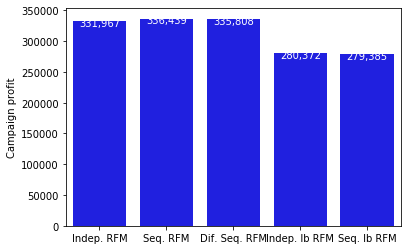

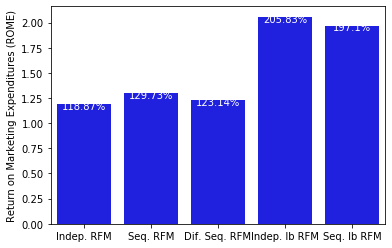

In [336]:
# Create profit and ROME plots:
dat = pd.DataFrame(
    {
        "name": [
            "Indep. RFM",
            "Seq. RFM",
            "Dif. Seq. RFM",
            "Indep. lb RFM",
            "Seq. lb RFM",
        ],
        "Profit": [
            profit_iq,
            profit_sq,
            profit_filsq,
            profit_lbiq,
            profit_lbsq,
        ],
        "ROME": [ROME_iq, ROME_sq, ROME_filsq, ROME_lbiq, ROME_lbsq],
    }
)

plt.clf()
fig = sns.barplot(x="name", y="Profit", color="blue", data=dat)
fig.set(xlabel="", ylabel="Campaign profit")
for index, row in dat.iterrows():
    fig.text(
        row.name, row.Profit - 8000, f"{int(row.Profit):,}", ha="center", color="white"
    )
plt.show()

plt.clf()
fig = sns.barplot(x="name", y="ROME", color="blue", data=dat)
fig.set(xlabel="", ylabel="Return on Marketing Expenditures (ROME)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.ROME - 0.05,
        f"{round((100*row.ROME), 2):,}%",
        ha="center",
        color="white",
    )
plt.show()